## Disaster or not: Text Classification using BERT

In [8]:
!wget https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab3/disaster_data.zip?raw=true -O disaster_data.zip

!unzip disaster_data.zip


--2021-03-16 06:05:24--  https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab3/disaster_data.zip?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab3/disaster_data.zip?raw=true [following]
--2021-03-16 06:05:25--  https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab3/disaster_data.zip?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab3/disaster_data.zip [following]
--2021-03-16 06:05:25--  https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab3/disaster_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ravi-ilango/aicamp-mar-2021/main/la

In [1]:
!pip install transformers

In [2]:
# imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, AdamW

import numpy as np
import pandas as pd
import os

from tqdm import trange

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_path = './bert_disaster_detection_state_dict.pth'

### Load data

In [4]:
#
# queries are stored in the variable query_text
# correct intent labels are stored in the variable labels
#
query_text = pd.read_csv('./disaster_data/train.csv').text.values
labels = pd.read_csv('./disaster_data/train.csv').target.values

print(query_text.shape)

(7613,)


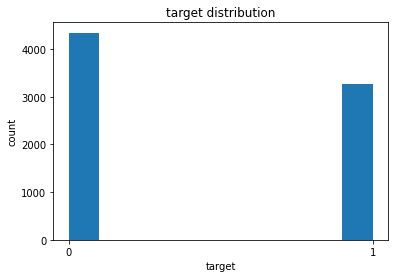

In [5]:
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('count')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Prepare Data


In [6]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
padded_sequences = tokenizer(list(query_text), padding=True)
print (f"tokenized inputs {padded_sequences['input_ids'][0]}")



tokenized inputs [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
padded_sequences.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Split into train and validation datasets

In [8]:
# Use train_test_split to split our data into train and validation sets for training
input_ids = padded_sequences['input_ids']
attention_masks = padded_sequences['attention_mask']

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


### Convert data into torch tensors

In [9]:
# Convert data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Create a data generator (iterator) for the train and validation data

In [10]:
batch_size = 32

# Create an iterator of train data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create an iterator of validation data with torch DataLoader 
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Load pretrained BERT model


In [11]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print (torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

num_labels = 2

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=num_labels)
model.to(device)

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))


Loading weights from saved model...


### Model Train function

In [14]:
def train(model, iterator, optimizer):

    model.train()  

    epoch_loss = 0

    for step, batch in enumerate(iterator):
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #resets the gradients after every batch
        optimizer.zero_grad()

        # Forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output['loss']
        
        # Backward pass
        loss.backward()
        
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        
        # loss
        epoch_loss += loss.item()

        if step%50==0:
            print (f"step: {step}")

    
    return epoch_loss / len(iterator)

### Model Evaluate function

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Evaluate
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    for batch in iterator:
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #deactivates autograd
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output['logits']

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        epoch_acc += tmp_eval_accuracy
        
    return epoch_acc / len(iterator)

### Train and Validate
This step takes ~3min


In [16]:
N_EPOCHS = 3
best_valid_acc = 0

# BERT training loop
for _ in trange(N_EPOCHS, desc="Epoch"):  

    #train the model
    train_loss = train(model, train_dataloader, optimizer)
    
    #evaluate the model
    valid_acc = evaluate(model, validation_dataloader)
    
    #save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        print ("saving model ...")
        torch.save(model.state_dict(), model_path)
    
    print(f'\t Train Loss: {train_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

step: 0
step: 50
step: 100
step: 150
step: 200
saving model ...


Epoch:  33%|███▎      | 1/3 [01:02<02:04, 62.03s/it]

	 Train Loss: 0.340 | Val. Acc: 85.27%
step: 0
step: 50
step: 100
step: 150
step: 200


Epoch:  67%|██████▋   | 2/3 [02:02<01:01, 61.70s/it]

	 Train Loss: 0.266 | Val. Acc: 84.22%
step: 0
step: 50
step: 100
step: 150
step: 200


Epoch: 100%|██████████| 3/3 [03:03<00:00, 61.28s/it]

	 Train Loss: 0.197 | Val. Acc: 83.70%


### Predict

In [17]:
#load weights
model.to('cpu')
model.load_state_dict(torch.load(model_path))
model.eval()

def predict(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    output = model(**inputs)
    logits = output.logits
    logits = logits.detach().cpu().numpy()

    pred = np.argmax(logits, axis=1)[0]
    return 'Disaster' if pred == 1 else 'Not a disaster'

In [18]:
predict(model, "Forest fire near La Ronge Sask. Canada")


'Disaster'

In [19]:
predict(model, "The weather is awesome")


'Not a disaster'